# Combining sources
This document combines all relevant sources into two datasets:
- daily downloads across all shows
- episodic totals, tagged by show

Sources:
- [x] Legacy LibSyn
- [x] Legacy HIO Sounder.fm
- [x] Simplecast HIO
- [x] Simplecast TBP
- [ ] ~~Legacy SoundCloud~~
- [ ] ~~Spotify~~ only 1k (+1k from old) streams for HIO
- [ ] ~~YouTube (maybe)~~ 8.7k views over TBP lifetime
- [ ] TBP Patreon

In [7]:
import pandas as pd
%matplotlib inline
import matplotlib as plt
plt.style.use('ggplot')

## Simplecast (Both HIO and TBP)

The timeline ranges from XXX - Current

for details on data files, review the "Exploring_Simplecast.ipynb" file

So far, we have not created proper data for the daily stats. They need to be pulled from episodic data and tallied, which requires quite a bit of work. 

In [13]:
hio_simplecast_episodic = pd.read_feather("hio_episodic_downloads.feather")
tbp_simplecast_episodic = pd.read_feather("tbp_episodic_downloads.feather")
simplecast_totals = pd.read_feather("total_podcast_downloads.feather")

## Legacy Libsyn

The timeline ranges from 2015-06-15 - 2019-02-17

for details on data files, review the "Exploring-downloads.ipynb" file

In [4]:
tbp_libsyn_episodic = pd.read_csv("dash_app/episode_data.csv")

<AxesSubplot: xlabel='release_date'>

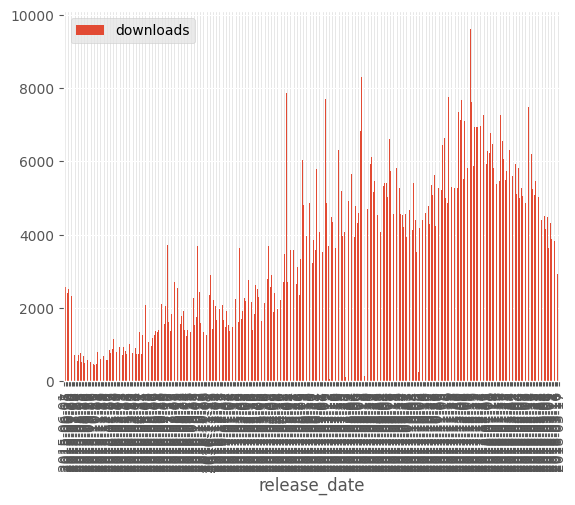

In [12]:
tbp_libsyn_episodic.plot.bar(x='release_date',y='downloads')

## Legacy Sounder.fm

In [15]:
hio_sounder_episodic = pd.read_csv("raw_data/hio_sounder/episodes_summary.csv")

In [16]:
hio_sounder_episodic

,organization_id,organization_title,show_id,show_title,episode_id,episode_title,episode_release_date,episode_create_date,streams_first_day,streams_second_day,streams_first_week,streams_first_month,streams_all_time,listeners_first_day,listeners_second_day,listeners_first_week,listeners_first_month,listeners_all_time
0,149,The Bitcoin Podcast Network,6234,Hashing It Out,61072,Hashing It Out #1: Nick Johnson,2018-04-03 19:58:51,2020-08-14 21:17:45,0,0,0,0,132,0,0,0,0,104
1,149,The Bitcoin Podcast Network,6234,Hashing It Out,61013,Hashing It Out #66 - Trueblocks - Thomas Jay Rush,2019-11-08 03:35:19,2020-08-14 21:17:43,0,0,0,0,67,0,0,0,0,33
2,149,The Bitcoin Podcast Network,6234,Hashing It Out,61028,Hashing It Out #45 - Cosmos Network - Zaki Manian,2019-05-10 17:41:37,2020-08-14 21:17:43,0,0,0,0,70,0,0,0,0,38
3,149,The Bitcoin Podcast Network,6234,Hashing It Out,61022,Hashing It Out #51 - Blockstream - Andrew Poel...,2019-07-04 19:48:18,2020-08-14 21:17:43,0,0,0,0,48,0,0,0,0,18
4,149,The Bitcoin Podcast Network,6234,Hashing It Out,61017,Hashing It Out #56 - Mattereum - Vinay Gupta,2019-08-16 12:29:42,2020-08-14 21:17:43,0,0,0,0,41,0,0,0,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,149,The Bitcoin Podcast Network,6234,Hashing It Out,494774,Flash Hash: 12/05/2022,2022-12-06 03:30:00,2022-12-06 02:24:05,82,11,120,147,150,78,9,108,122,124
128,149,The Bitcoin Podcast Network,6234,Hashing It Out,495947,Application infrastructure Pt. 2,2022-12-13 19:19:37,2022-12-13 19:19:37,46,45,110,135,136,44,41,100,106,107
129,149,The Bitcoin Podcast Network,6234,Hashing It Out,496445,Hashing It Out Personals: Dee Ferguson,2022-12-19 03:47:17,2022-12-19 03:47:17,48,36,123,153,153,43,34,108,127,127
130,149,The Bitcoin Podcast Network,6234,Hashing It Out,497775,Flash Hash 01/02/2023,2023-01-02 22:11:26,2023-01-02 22:11:26,0,78,110,111,111,0,74,104,105,105
